In [ ]:
import warnings
warnings.filterwarnings('ignore')
import re
import matplotlib.pyplot as plt

In [ ]:
import os

DATASET_IMAGES_DIR = "/Users/akhilalocan/Desktop/Flickr8k/Images"    # Defining the directory path to the dataset images
CAPTIONS_FILE_PATH = "/Users/akhilalocan/Desktop/Flickr8k/text"      # Defining the file path to the caption data
TARGET_IMAGE_DIMS = (299, 299)                                       # Setting target dimensions to resize images for model compatibility
MAX_SEQUENCE_LENGTH = 35                                             # Maximum allowed sequence length for caption text input
MAX_VOCAB_SIZE = 10000                                               # Total unique words allowed in the vocabulary
EMBEDDING_DIMENSION = 64                                             # Embedding dimension for both image and text data representations
FEED_FORWARD_DIM = 64                                                # Number of units in each layer of the feed-forward network
TRAINING_BATCH_SIZE = 64                                             # Number of samples to process per training batch
TRAINING_EPOCHS = 60                                                 # Total number of training iterations over the dataset


In [ ]:
# Importing necessary modules
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load captions from file and associate them with corresponding images
def load_captions_data(captions_filepath):
    # Open and read the captions file, skipping the first line
    with open(captions_filepath) as caption_file:
        caption_lines = caption_file.readlines()[1:]
        image_caption_map = {}  # Stores mapping of image names to captions
        captions_list = []      # Stores all captions as text data
        skipped_images = set()   # Tracks images with captions that are too short or too long

        for line in caption_lines:
            line = line.rstrip("\n")
            # Split each line to separate image name and caption
            image_name, caption_text = line.split(",", 1)
            image_path = os.path.join(DATASET_IMAGES_DIR, image_name.strip())

            # Tokenize the caption and check its length
            tokens = caption_text.strip().split()
            if len(tokens) < 5 or len(tokens) > MAX_SEQUENCE_LENGTH:
                skipped_images.add(image_path)
                continue

            # Add start and end tokens to the caption
            caption_text = "<start> " + caption_text.strip() + " <end>"
            captions_list.append(caption_text)

            # Append caption to the mapping if image_path is valid and unique
            if image_path.endswith("jpg") and image_path not in skipped_images:
                if image_path in image_caption_map:
                    image_caption_map[image_path].append(caption_text)
                else:
                    image_caption_map[image_path] = [caption_text]

        # Remove skipped images from the final mapping
        for image_path in skipped_images:
            if image_path in image_caption_map:
                del image_caption_map[image_path]

        return image_caption_map, captions_list

# Function to split the dataset into training, validation, and test sets
def train_val_split(caption_mapping, validation_ratio=0.2, test_ratio=0.05, shuffle=True):
    # Get list of all image paths
    all_image_paths = list(caption_mapping.keys())

    # Shuffle the list if required
    if shuffle:
        np.random.shuffle(all_image_paths)

    # Split the data into training and validation sets
    train_keys, validation_keys = train_test_split(all_image_paths, test_size=validation_ratio, random_state=42)

    # Map image paths to their captions for each split
    train_captions = {image: caption_mapping[image] for image in train_keys}
    validation_captions = {image: caption_mapping[image] for image in validation_keys}
    test_data = {image: caption_mapping[image] for image in test_keys}

    return train_captions, validation_captions

# Loading captions and mapping to corresponding images
captions_map, captions_text = load_captions_data(CAPTIONS_FILE_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of test samples: {len(test_data)}")

Total number of samples: 7643
Number of training samples: 6114
Number of validation samples: 1452
Number of test samples: 77


In [ ]:
# Import necessary libraries
import tensorflow as tf
import keras
from keras.layers import TextVectorization
import re
from keras import layers

# Custom function to standardize captions by removing unwanted characters and lowercasing
def custom_standardization(input_text):
    # Convert all text to lowercase
    lowercase_text = tf.strings.lower(input_text)
    # Define characters to strip (punctuation and numbers)
    unwanted_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    # Replace unwanted characters with an empty string
    return tf.strings.regex_replace(lowercase_text, "[%s]" % re.escape(unwanted_chars), "")

# Defining text vectorization layer to convert text to integer sequences
text_vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,  # Maximum number of unique words in vocabulary
    output_mode="int",          # Output as integer indices
    output_sequence_length=MAX_SEQUENCE_LENGTH,  # Set max caption length with padding for shorter captions
    standardize=custom_standardization  # Apply custom standardization to captions
)

# Fit the text vectorizer on all caption data
text_vectorizer.adapt(captions_text)

# Data augmentation layer for image transformations to improve model robustness
image_augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.2),       # Randomly rotate images by up to 20%
    layers.RandomContrast(0.3)        # Randomly adjust image contrast by up to 30%
])

# Applying custom standardization to the text data
standardized_text_data = list(
    map(lambda caption: str(custom_standardization(caption).numpy())[2:-1], captions_text)
)


In [ ]:
# Function to read and preprocess images by resizing and normalizing
def decode_and_resize(image_path):
    # Read the image from the file path
    image = tf.io.read_file(image_path)
    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the specified dimensions
    image = tf.image.resize(image, TARGET_IMAGE_DIMS)
    # Convert image pixels to float32 and normalize between 0 and 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

# Function to process input by resizing image and vectorizing caption
def process_input(image_path, caption_text):
    # Processed image shape: (None, 299, 299, 3)
    # Vectorized caption shape: (None, None, 25)
    return decode_and_resize(image_path), text_vectorizer(caption_text)

# Function to prepare the dataset for training or validation
def make_dataset(image_paths, caption_texts):
    # Create a TensorFlow dataset from image paths and captions
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, caption_texts))
    # Shuffle the dataset with a buffer size 8 times the batch size
    dataset = dataset.shuffle(TRAINING_BATCH_SIZE * 8)
    # Apply processing functions to dataset elements with parallel mapping for efficiency
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch the dataset and prefetch to improve performance
    dataset = dataset.batch(TRAINING_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Creating the training and validation datasets using image paths and corresponding captions
train_dataset = make_dataset(list(training_captions.keys()), list(training_captions.values()))
validation_dataset = make_dataset(list(validation_captions.keys()), list(validation_captions.values()))


# Model Building

CNN Model

In [ ]:
# Import necessary modules and layers
from tensorflow.keras import layers, models
from tensorflow.keras.applications import efficientnet
import tensorflow as tf

# Define CNN model with EfficientNetB0 as the feature extractor
def build_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*TARGET_IMAGE_DIMS, 3),
        include_top=False, # Removing the prediction layers
        weights="imagenet")

    # Freeze the weights of EfficientNetB0
    base_model.trainable = False

    # Reshape output to fit into the Transformer encoder
    cnn_output = layers.Reshape((-1, base_model.output.shape[-1]))(base_model.output)
    cnn_model = models.Model(base_model.input, cnn_output)

    return cnn_model



Transformer Model

In [ ]:
# Define Transformer Encoder Block
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-Head Attention layer
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)

        # Layer Normalization
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()

        # Dense layer with ReLU activation
        self.dense = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # Apply Layer Normalization before the Dense layer
        normalized_inputs = self.layer_norm1(inputs)

        # Dense transformation
        transformed_inputs = self.dense(normalized_inputs)

        # Self-attention computation
        attention_output = self.self_attention(
            query=transformed_inputs, value=transformed_inputs, key=transformed_inputs,
            attention_mask=None, training=training)

        # Output after residual connection and normalization
        return self.layer_norm2(transformed_inputs + attention_output)


# Define Positional Embedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        seq_length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=seq_length, delta=1)

        # Scale the token embeddings and add position embeddings
        token_embeddings = self.token_embedding(inputs) * self.embed_scale
        position_embeddings = self.position_embedding(positions)

        # Return summed token and positional embeddings
        return token_embeddings + position_embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)



In [ ]:
# Define Transformer Decoder Block
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        # Layers for self-attention, cross-attention, and feed-forward network
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.dense_1 = layers.Dense(ff_dim, activation="relu")
        self.dense_2 = layers.Dense(embed_dim)

        # Layer Normalization and Dropout layers
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.layer_norm3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(embed_dim=EMBEDDING_DIMENSION, sequence_length=MAX_SEQUENCE_LENGTH, vocab_size=MAX_VOCAB_SIZE)
        self.output_layer = layers.Dense(MAX_VOCAB_SIZE, activation="softmax")
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        # Generate input embedding with positional encoding
        embedded_inputs = self.embedding(inputs)
        causal_mask = self.create_causal_mask(embedded_inputs)

        # Apply masking for padding tokens if mask is provided
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # Self-attention computation with combined mask
        self_attention_output = self.self_attention(
            query=embedded_inputs, value=embedded_inputs, key=embedded_inputs,
            attention_mask=combined_mask, training=training)

        # Output after residual connection and normalization
        norm_self_attention = self.layer_norm1(embedded_inputs + self_attention_output)

        # Cross-attention with encoder output and padding mask
        cross_attention_output = self.cross_attention(
            query=norm_self_attention, value=encoder_outputs, key=encoder_outputs,
            attention_mask=padding_mask, training=training)

        # Output after residual connection and normalization
        norm_cross_attention = self.layer_norm2(norm_self_attention + cross_attention_output)

        # Feed-forward network with dropout and residual connection
        ffn_output = self.dense_1(norm_cross_attention)
        ffn_output = self.dropout_1(ffn_output, training=training)
        ffn_output = self.dense_2(ffn_output)

        norm_ffn_output = self.layer_norm3(ffn_output + norm_cross_attention)
        final_output = self.dropout_2(norm_ffn_output, training=training)

        # Final prediction with Dense layer
        return self.output_layer(final_output)

    def create_causal_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_length = input_shape[0], input_shape[1]
        i = tf.range(seq_length)[:, tf.newaxis]
        j = tf.range(seq_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, seq_length, seq_length))
        return tf.tile(mask, [batch_size, 1, 1])

In [ ]:
# Define the Image Captioning Model class
class ImageCaptioningModel(models.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_augmentation=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_augmentation = image_augmentation

    # Method for calculating the masked loss
    def calculate_masked_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    # Method for calculating the masked accuracy
    def calculate_masked_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

# Instantiate CNN model, encoder, and decoder
cnn_model = build_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBEDDING_DIMENSION, dense_dim=FEED_FORWARD_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBEDDING_DIMENSION, ff_dim=FEED_FORWARD_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder)#image_augmentation=image_augmentation)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

CNN input shape: (None, 299, 299, 3)
CNN output shape: (None, 100, 1280)

Encoder input ---> Dense layer shape: (None, 100, 1280) ---> (None, 100, 64)
Encoder output shape: (None, 100, 64)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 24) ---> (None, 24, 64)
Decoder input 2 (Embedded image features) shape: (None, 100, 64)
Decoder output (MH Cross-Attention) shape: (None, 24, 64)
Decoder prediction (Dense layer) shape: (None, 24, 10000)


In [ ]:
# Define the cross-entropy loss function for training
# `from_logits=False` because the final activation in the decoder is softmax
caption_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping callback to stop training if the validation loss does not improve for 3 consecutive epochs
early_stopping_criteria = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Custom Learning Rate Scheduler for the optimizer
class LearningRateSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, target_learning_rate, warmup_steps):
        super().__init__()
        self.target_learning_rate = target_learning_rate
        self.warmup_steps = warmup_steps

    # Adjust the learning rate dynamically during training
    def __call__(self, step):
        # Convert step and warmup_steps to float for calculation
        current_step = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)

        # Calculate learning rate progress for the warmup phase
        warmup_progress = current_step / warmup_steps_float
        warmup_lr = self.target_learning_rate * warmup_progress

        # Return warmup rate if in warmup steps, else final learning rate
        return tf.cond(
            current_step < warmup_steps_float,
            lambda: warmup_lr,
            lambda: self.target_learning_rate)

    # Configuration for saving and reloading the schedule if needed
    def get_config(self):
        return {
            "target_learning_rate": self.target_learning_rate,
            "warmup_steps": self.warmup_steps
        }

# Define the total training steps and warmup steps
# `total_train_steps` is calculated based on the number of batches and epochs
total_train_steps = len(train_dataset) * EPOCHS
warmup_steps = total_train_steps // 15

# Initialize the learning rate scheduler with specified warmup and target learning rate
learning_rate_schedule = LearningRateSchedule(target_learning_rate=1e-4, warmup_steps=warmup_steps)

# Compile the Image Captioning model with Adam optimizer and the custom learning rate schedule
caption_model.compile(optimizer=keras.optimizers.Adam(learning_rate_schedule), loss=caption_loss)

# Start training the model, with validation and early stopping callback
# The model stops if validation loss does not improve for 3 epochs
training_history = caption_model.fit(
    train_dataset, epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping_criteria]
)


Epoch 1/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 769s 8s/step - acc: 0.0410 - loss: 44.5963 - val_acc: 0.1322 - val_loss: 32.6225
Epoch 2/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 711s 7s/step - acc: 0.1252 - loss: 30.1851 - val_acc: 0.1318 - val_loss: 26.9828
Epoch 3/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 712s 7s/step - acc: 0.1534 - loss: 26.7731 - val_acc: 0.2119 - val_loss: 24.6891
Epoch 4/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 711s 7s/step - acc: 0.2211 - loss: 24.6414 - val_acc: 0.2627 - val_loss: 22.7001
Epoch 5/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 710s 7s/step - acc: 0.2643 - loss: 22.9593 - val_acc: 0.2925 - val_loss: 21.3734
Epoch 6/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 707s 7s/step - acc: 0.2879 - loss: 21.7552 - val_acc: 0.3097 - val_loss: 20.4948
Epoch 7/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 710s 7s/step - acc: 0.3008 - loss: 20.9930 - val_acc: 0.3161 - val_loss: 19.9115
Epoch 8/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 710s 7s/step - acc: 0.3102 - loss: 20.3913 - val_acc: 0.3228 - val_loss: 19.4474
Epoch 9/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 708s 7s/st

## Model Saving

In [ ]:
#SAVE THE MODEL

caption_model.save('caption_model.keras')

In [ ]:
load_model = keras.models.load_model('caption_model.keras')


## Performance Plots

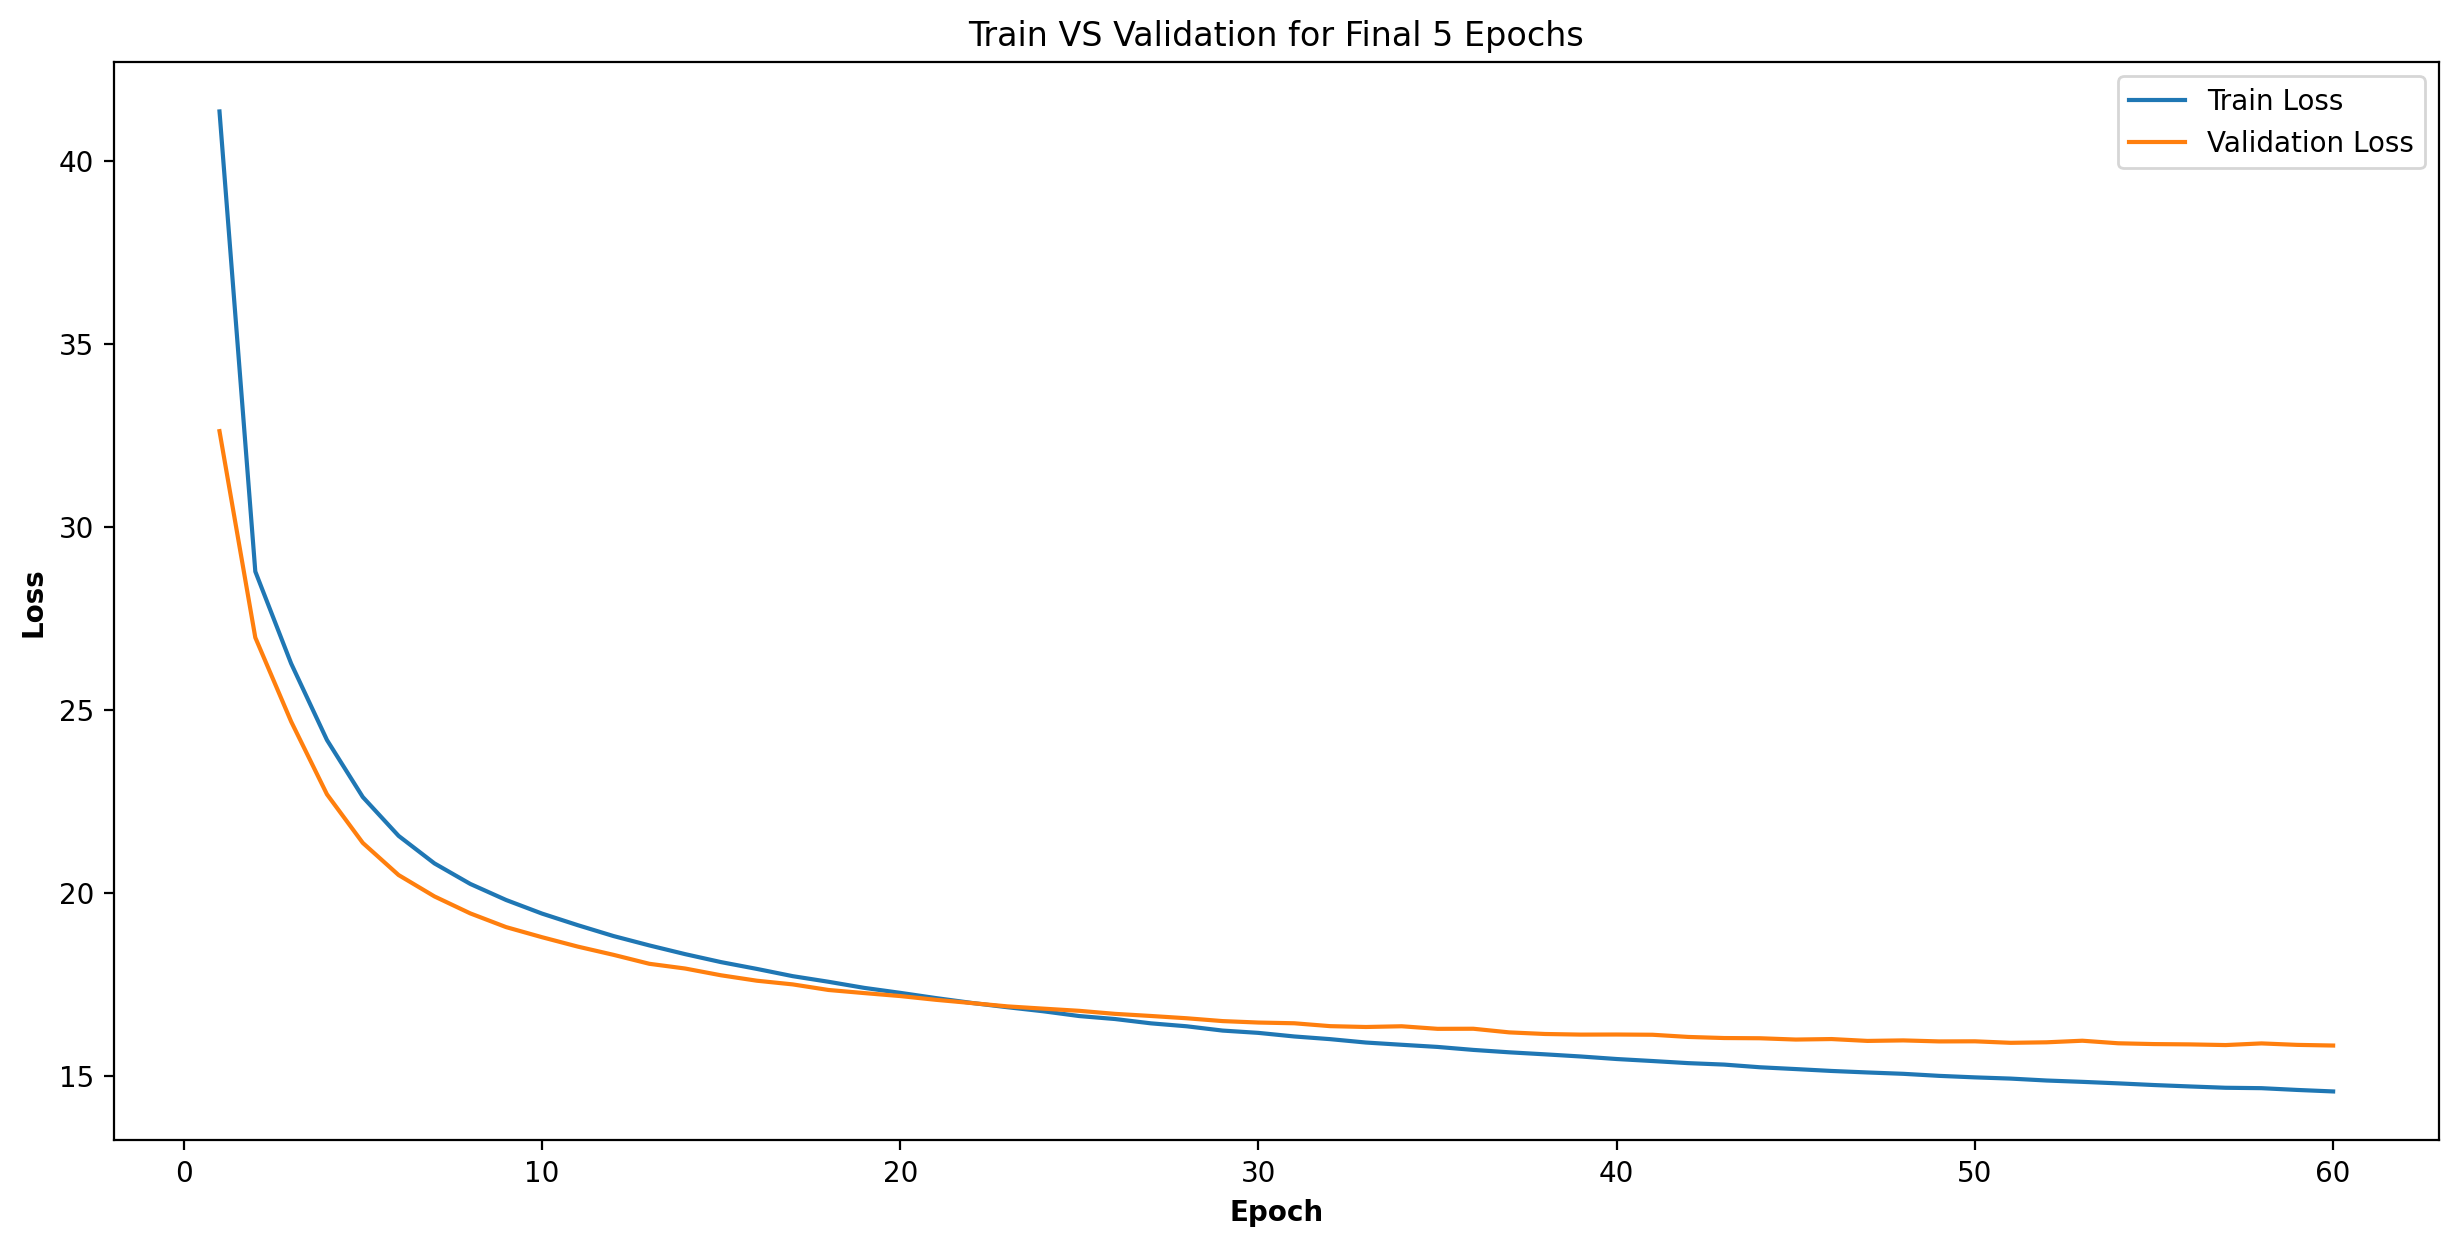

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'])
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'])
plt.title('Train VS Validation for Final 5 Epochs')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

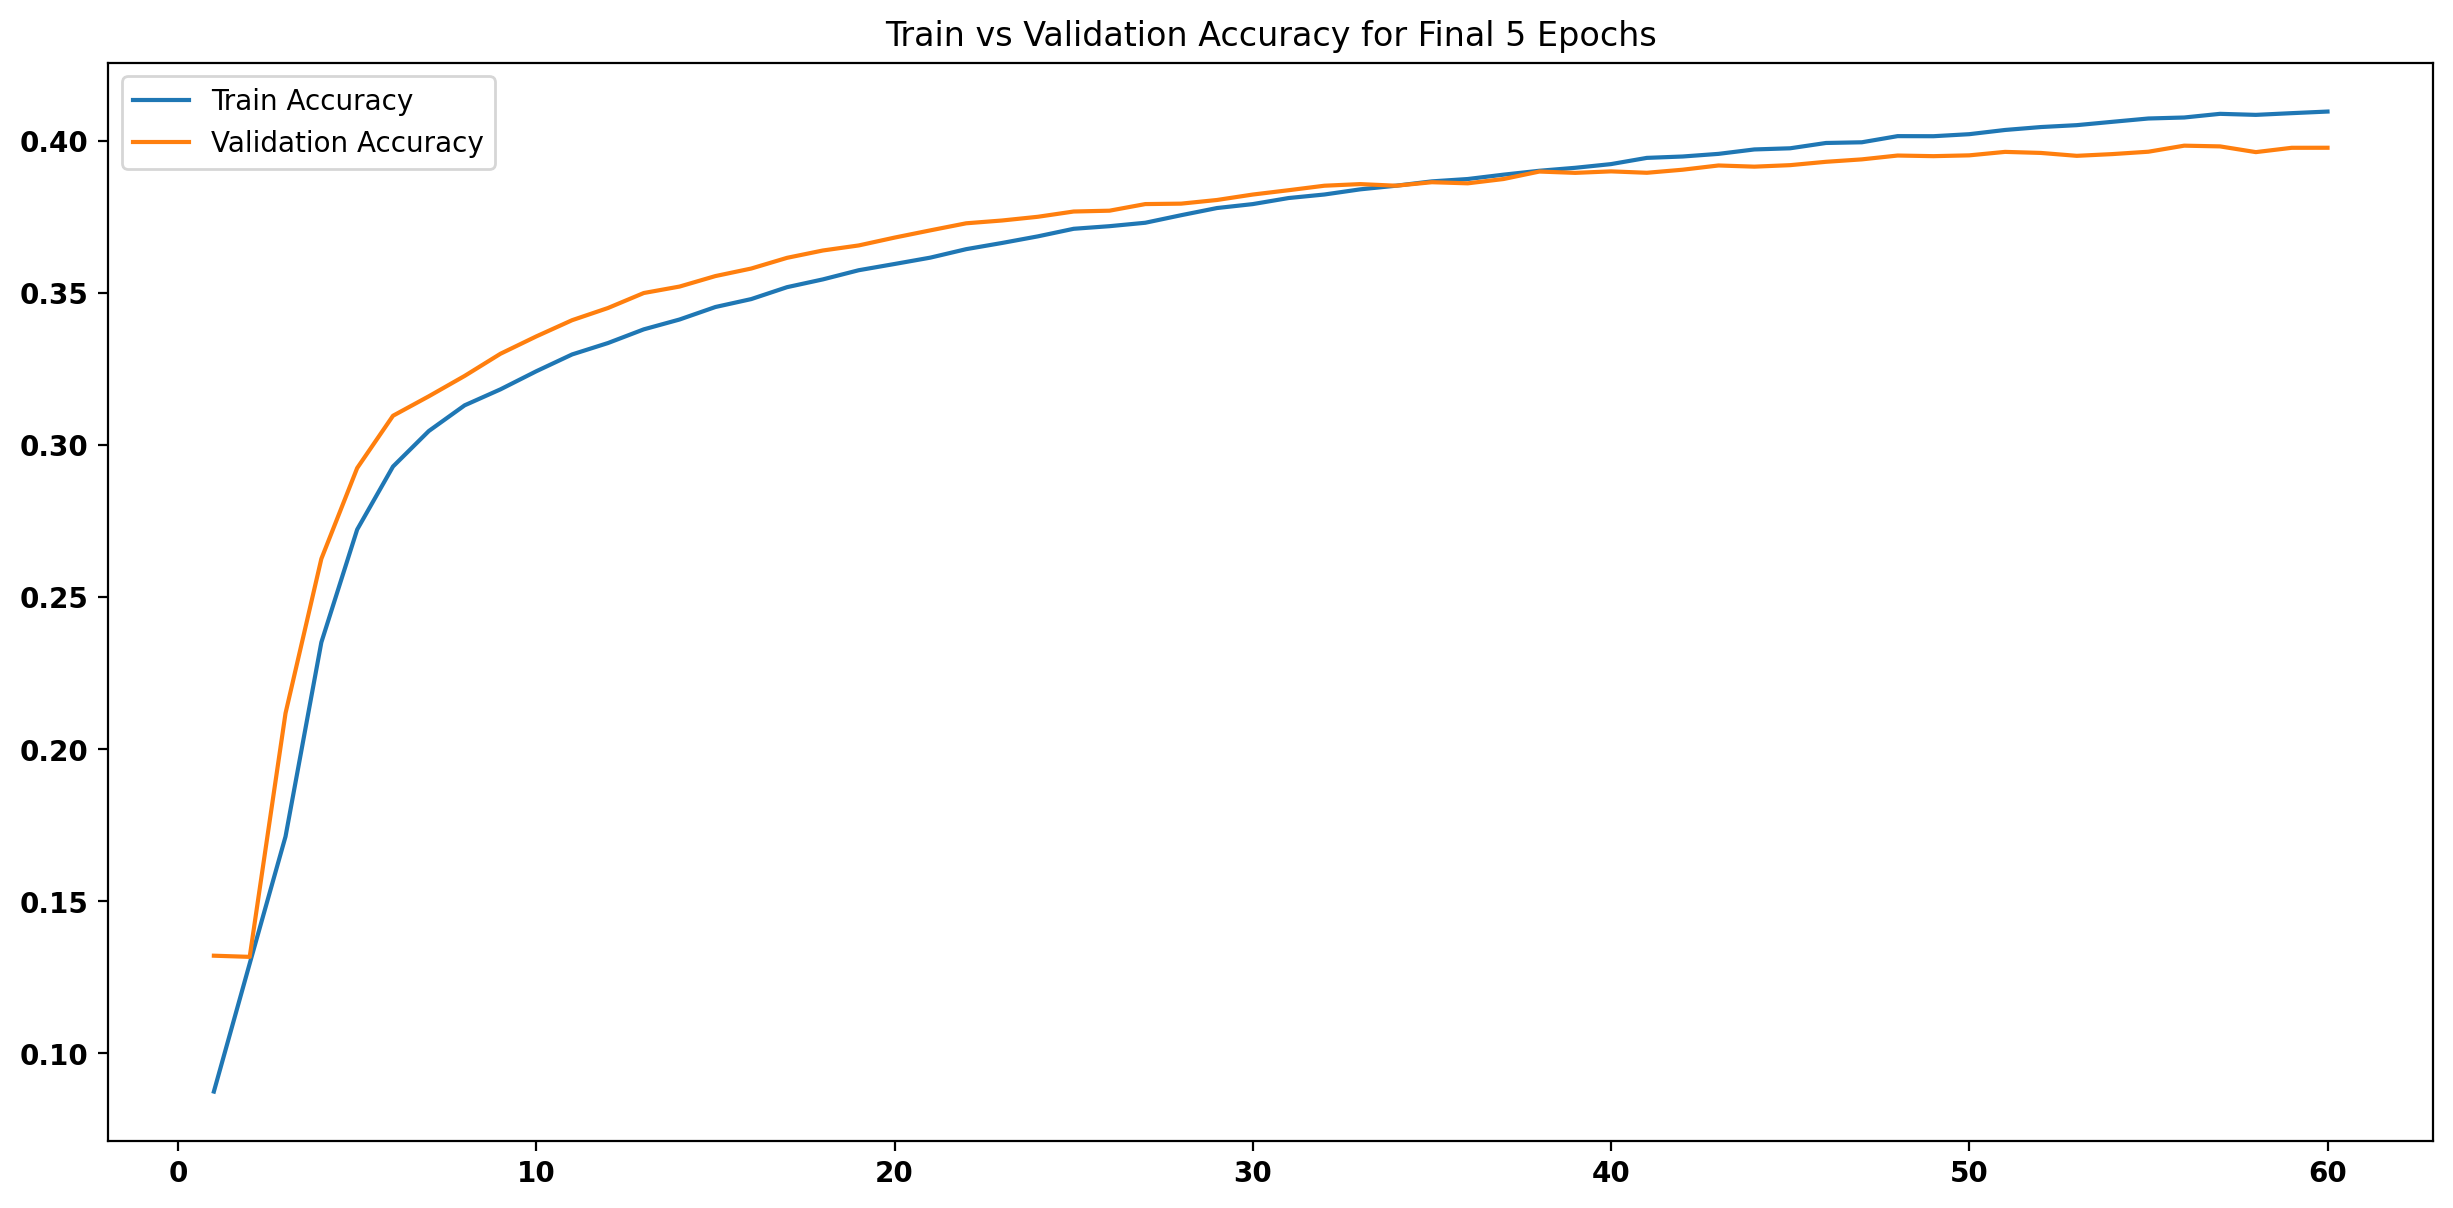

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(15, 7), dpi=200)
plt.plot([x+1 for x in range(len(history.history['acc']))], history.history['acc'])
plt.plot([x+1 for x in range(len(history.history['acc']))], history.history['val_acc'])
plt.title('Train vs Validation Accuracy for Final 5 Epochs')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

## Model Testing

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
import pickle
import os
import tensorflow as tf

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    """Loads and preprocesses the image for the model."""
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to generate a caption for the uploaded image
def generate_caption_for_image(image_path, model, vectorizer, index_to_word):
    """Generates a caption for a given image using the trained model."""
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Extract features using the CNN
    image_features = caption_model.cnn_model(processed_image)

    # Pass the features to the Transformer encoder
    encoded_img = caption_model.encoder(image_features, training=False)

    # Generate caption using the decoder
    decoded_caption = "<start>"
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_to_word[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    # Clean up the final caption
    final_caption = decoded_caption.replace("<start>", "").strip()
    return final_caption


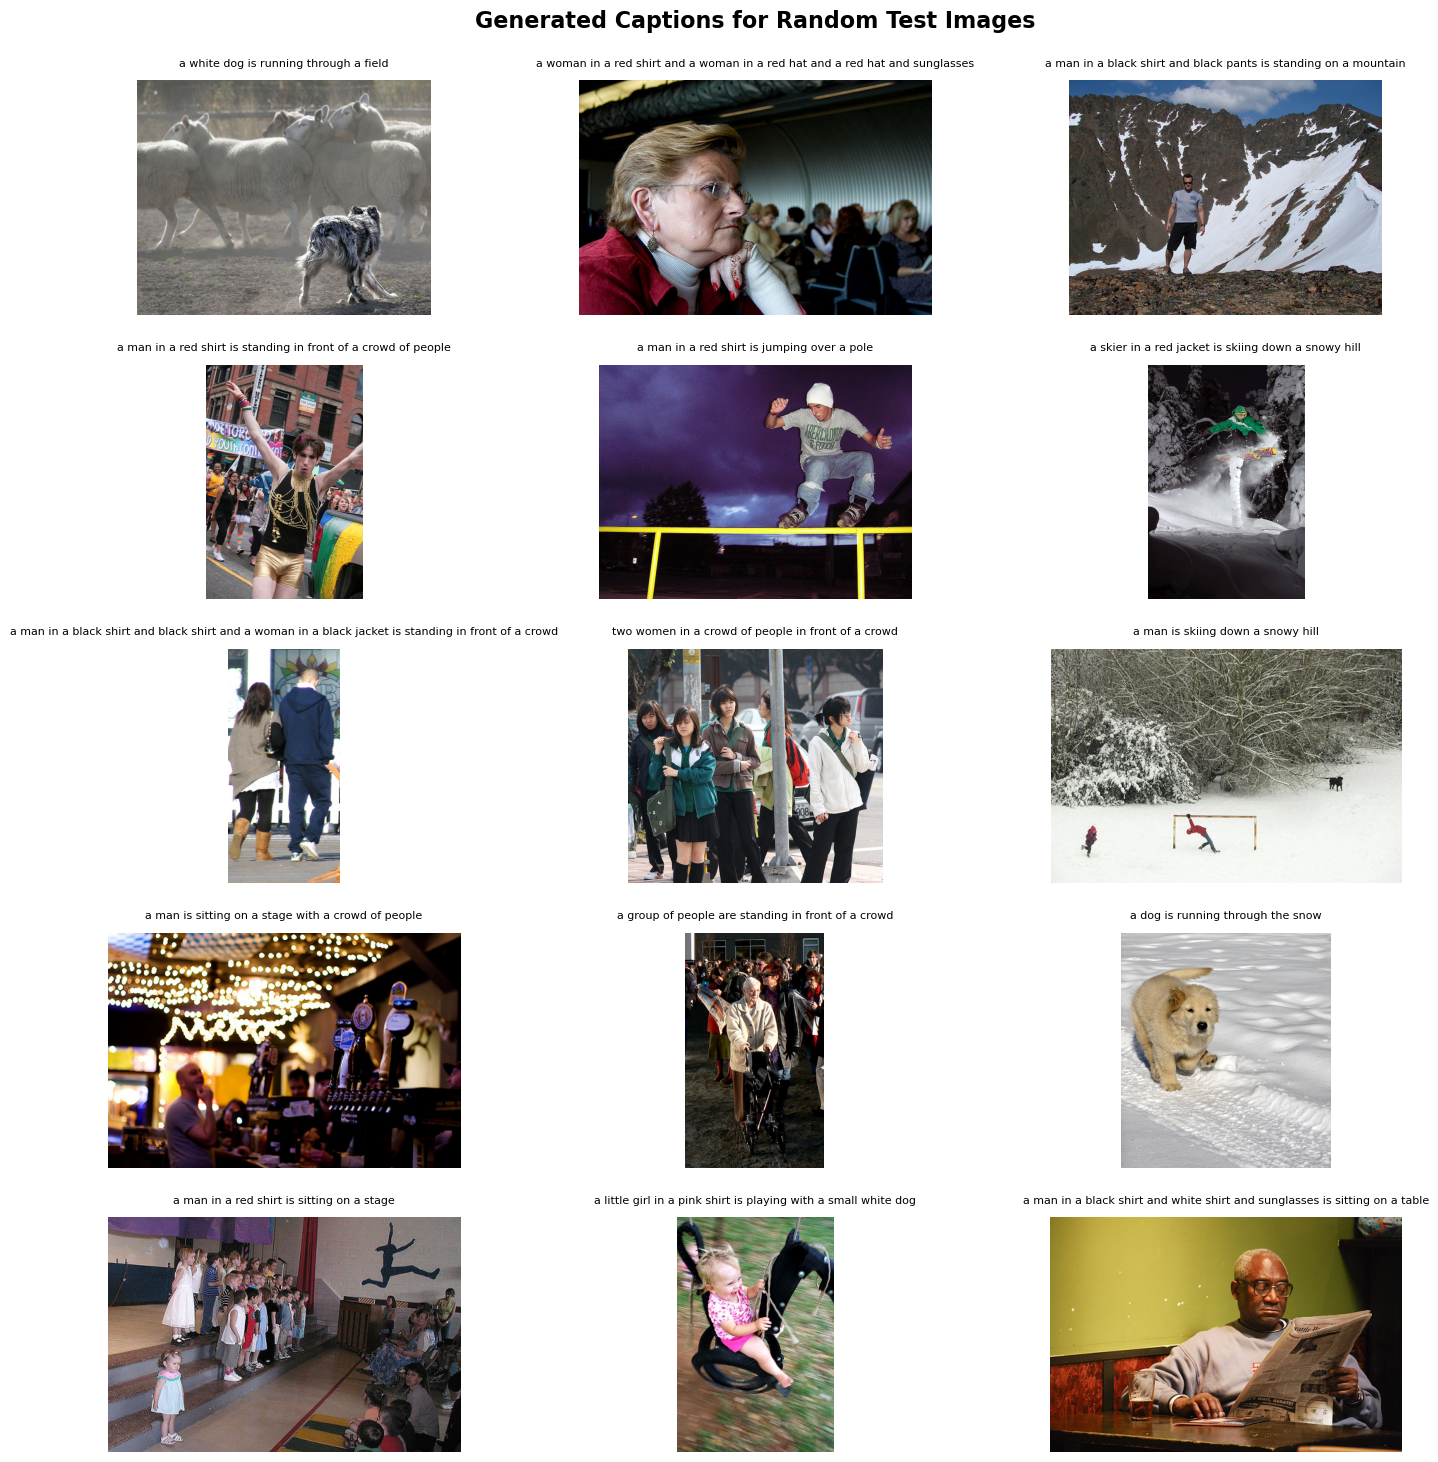

In [ ]:
# Randomly select 30 images from the test dataset and plot them
def plot_random_images_with_captions(test_data, num_images=15):
    # Randomly select images from the test dataset
    selected_images = random.sample(list(test_data.items()), num_images)

    plt.figure(figsize=(15, 15))  # Increased figure size for more space
    for idx, (image_path, actual_captions) in enumerate(selected_images):
        generated_caption = generate_caption_for_image(image_path, caption_model, vectorization, INDEX_TO_WORD)

        # Load and display each image with caption below
        image = Image.open(image_path)
        plt.subplot(5, 3, idx + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(generated_caption, fontsize=8, pad=10)  # Increased padding below title for separation

    # Use constrained layout to manage spacing between subplots and avoid overlap
    plt.suptitle("Generated Captions for Random Test Images", fontsize=16, fontweight='bold')
    plt.tight_layout(pad=2.0)  # Additional padding between plots
    plt.show()

# Call the function to display random images
plot_random_images_with_captions(test_data)

In [ ]:
# Function to generate and save captions for images in the test dataset
def generate_and_save_test_data_captions(test_data, caption_model, vectorizer, index_to_word):
    """Generate captions for the test dataset and save them."""
    captions_dict = {}

    # Generate captions for each image in the test_data
    for image_id in test_data:
        # Assuming 'image_id' is the file path or unique ID of the image
        generated_caption = generate_caption_for_image(image_id, caption_model, vectorizer, index_to_word)

        # Store the generated caption
        captions_dict[image_id] = generated_caption

    # Save the captions dictionary to a file
    save_captions_to_file(captions_dict)

    return captions_dict

# Save the generated captions to a file
def save_captions_to_file(captions_dict, filename='test_data_predictions.pkl'):
    """Save the generated captions dictionary to a pickle file."""
    with open(filename, 'wb') as f:
        pickle.dump(captions_dict, f)
    print(f"Captions saved to {filename}")

# Example: Save to the current working directory or specify a full path
captions_dict = generate_and_save_test_data_captions(test_data, caption_model, vectorization, INDEX_TO_WORD)

# Specify the path where you want to save the file
save_captions_to_file(captions_dict, 'test_data_predictions.pkl')  # Save to the same directory as the notebook

Captions saved to test_data_predictions.pkl
Captions saved to test_data_predictions.pkl


In [ ]:
import pickle

# Load the generated captions from the saved pickle file
def load_captions_from_file(filename='generated_captions_test_data_new.pkl'):
    with open(filename, 'rb') as f:
        captions_dict = pickle.load(f)
    print(f"Captions loaded from {filename}")
    return captions_dict

# Example: Load the file
captions_dict_new = load_captions_from_file('test_data_predictions.pkl')  


Captions loaded from test_data_predictions.pkl


In [ ]:
save_captions_to_file(test_data, 'test_data.pkl')  # Save to the same directory as the notebook

Captions saved to test_data.pkl
